In [1]:

import pandas as pd
import numpy as np
import os
from keras.models import Sequential,Model
from keras.layers import *

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import load_model
import keras
from keras import backend as K

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
from imageloader import data_process
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import copy
from keras.preprocessing import sequence
import matplotlib.cm as cmp

Using TensorFlow backend.


In [2]:
#reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',factor=0.5, patience=20)
#model save
MODEL_SAVE_FOLDER_PATH = '../model/lstm'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                                verbose=1, save_best_only=True)


#early_stopping = EarlyStopping()

# Minmax 
scaler = MinMaxScaler()
scaler_ = MinMaxScaler()

In [3]:
#숫자인지 아닌지
number = False


if(number):
  dp = data_process('./DATA/aug/all/train/number',number)
  dp.point_data_load()
  #dp.image_read()
  dp.sequence_50()
  dp.image_make()
  dp.data_shuffle()

  class_num = 10

else:
  dp_train = data_process('./DATA/aug/all/train/Alphabet',number)
  dp_train.point_data_load()
  #dp.image_read()
  dp_train.sequence_50()
  dp_train.image_make()
  dp_train.data_shuffle()
  train_len = np.size(dp_train.point,0)
  print(train_len)

  
  dp_test = data_process('./DATA/aug/all/test/Alphabet',number)
  dp_test.point_data_load()
  #dp.image_read()
  dp_test.sequence_50()
  dp_test.image_make()
  dp_test.data_shuffle()
  test_len = np.size(dp_test.point,0)

  class_num = 26

--- 14.316288948059082 seconds ---
0
7047
--- 2.7487289905548096 seconds ---
0


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


In [5]:
X_train = dp_train.images[:]
X_test = dp_test.images[:]
Y_train = dp_train.label[:]
Y_test = dp_test.label[:]


Y_train = keras.utils.to_categorical(Y_train,num_classes=class_num, dtype='float32')
Y_test = keras.utils.to_categorical(Y_test,num_classes=class_num, dtype='float32')

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding="valid",input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.45))

model.add(Conv2D(64, kernel_size=3, padding="valid"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.45))

model.add(Conv2D(128, kernel_size=3, padding="valid"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.45))

model.add(Conv2D(256, kernel_size=3, padding="valid"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
#model.add(GlobalAveragePooling2D())
model.add(Dropout(0.45))

model.add(Dense(26,activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 64)        256       
__________

In [8]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001,epsilon=1e-04), metrics=['accuracy'])
hist_1 = model.fit(X_train, Y_train,
                batch_size=64,
                validation_data=(X_test,Y_test),
                epochs=250,
                verbose=1,
                callbacks=[cb_checkpoint,lr_reduce])


score = model.evaluate(X_test, Y_test, verbose=0)
pred = model.predict(X_test)
true_value = np.argmax(Y_test,1)
predict_value = np.argmax(pred,1)
print(np.argmax(pred,axis=1))
print(score[1]*100)
#print("복원된 모델의 정확도: {:5.2f}%".format(100*score))
list_ = []
for i in range(np.size(true_value,0)):
  if(true_value[i] != predict_value[i]):
    if(number):
      print('t:{},p:{}'.format(true_value[i],predict_value[i]))
    else:
      print('t:{},p:{}'.format(chr(97+true_value[i]),chr(97+predict_value[i])))
    list_.append(i)


Instructions for updating:
Use tf.cast instead.
Train on 7047 samples, validate on 1393 samples
Epoch 1/250
7047/7047 [==============================] - 3s 428us/step - loss: 2.8465 - acc: 0.1866 - val_loss: 5.0566 - val_acc: 0.1472

Epoch 00001: val_acc improved from -inf to 0.14716, saving model to ../model/lstm.hdf5
Epoch 2/250
7047/7047 [==============================] - 1s 147us/step - loss: 1.6644 - acc: 0.4740 - val_loss: 4.9141 - val_acc: 0.1938

Epoch 00002: val_acc improved from 0.14716 to 0.19383, saving model to ../model/lstm.hdf5
Epoch 3/250
7047/7047 [==============================] - 1s 118us/step - loss: 1.0302 - acc: 0.6591 - val_loss: 3.8391 - val_acc: 0.2764

Epoch 00003: val_acc improved from 0.19383 to 0.27638, saving model to ../model/lstm.hdf5
Epoch 4/250
7047/7047 [==============================] - 1s 125us/step - loss: 0.7078 - acc: 0.7664 - val_loss: 3.0088 - val_acc: 0.3352

Epoch 00004: val_acc improved from 0.27638 to 0.33525, saving model to ../model/lstm.

7047/7047 [==============================] - 1s 145us/step - loss: 0.0751 - acc: 0.9753 - val_loss: 0.5361 - val_acc: 0.9038

Epoch 00039: val_acc improved from 0.90309 to 0.90380, saving model to ../model/lstm.hdf5
Epoch 40/250
7047/7047 [==============================] - 1s 154us/step - loss: 0.0829 - acc: 0.9722 - val_loss: 0.4695 - val_acc: 0.9124

Epoch 00040: val_acc improved from 0.90380 to 0.91242, saving model to ../model/lstm.hdf5
Epoch 41/250
7047/7047 [==============================] - 1s 119us/step - loss: 0.0857 - acc: 0.9720 - val_loss: 0.4633 - val_acc: 0.9060

Epoch 00041: val_acc did not improve from 0.91242
Epoch 42/250
7047/7047 [==============================] - 1s 129us/step - loss: 0.0703 - acc: 0.9779 - val_loss: 0.5379 - val_acc: 0.9024

Epoch 00042: val_acc did not improve from 0.91242
Epoch 43/250
7047/7047 [==============================] - 1s 112us/step - loss: 0.0752 - acc: 0.9750 - val_loss: 0.4890 - val_acc: 0.9067

Epoch 00043: val_acc did not improve f

7047/7047 [==============================] - 1s 98us/step - loss: 0.0594 - acc: 0.9818 - val_loss: 0.4740 - val_acc: 0.9196

Epoch 00081: val_acc did not improve from 0.92749
Epoch 82/250
7047/7047 [==============================] - 1s 104us/step - loss: 0.0650 - acc: 0.9787 - val_loss: 0.4555 - val_acc: 0.9146

Epoch 00082: val_acc did not improve from 0.92749
Epoch 83/250
7047/7047 [==============================] - 1s 97us/step - loss: 0.0553 - acc: 0.9821 - val_loss: 0.4752 - val_acc: 0.9189

Epoch 00083: val_acc did not improve from 0.92749
Epoch 84/250
7047/7047 [==============================] - 1s 114us/step - loss: 0.0464 - acc: 0.9860 - val_loss: 0.5452 - val_acc: 0.9146

Epoch 00084: val_acc did not improve from 0.92749
Epoch 85/250
7047/7047 [==============================] - 1s 126us/step - loss: 0.0458 - acc: 0.9855 - val_loss: 0.5275 - val_acc: 0.9131

Epoch 00085: val_acc did not improve from 0.92749
Epoch 86/250
7047/7047 [==============================] - 1s 105us/ste

7047/7047 [==============================] - 1s 149us/step - loss: 0.0236 - acc: 0.9926 - val_loss: 0.5245 - val_acc: 0.9225

Epoch 00124: val_acc did not improve from 0.92749
Epoch 125/250
7047/7047 [==============================] - 1s 135us/step - loss: 0.0202 - acc: 0.9930 - val_loss: 0.5517 - val_acc: 0.9196

Epoch 00125: val_acc did not improve from 0.92749
Epoch 126/250
7047/7047 [==============================] - 1s 179us/step - loss: 0.0230 - acc: 0.9935 - val_loss: 0.5452 - val_acc: 0.9218

Epoch 00126: val_acc did not improve from 0.92749
Epoch 127/250
7047/7047 [==============================] - 1s 165us/step - loss: 0.0184 - acc: 0.9942 - val_loss: 0.5345 - val_acc: 0.9261

Epoch 00127: val_acc did not improve from 0.92749
Epoch 128/250
7047/7047 [==============================] - 1s 139us/step - loss: 0.0192 - acc: 0.9932 - val_loss: 0.5320 - val_acc: 0.9239

Epoch 00128: val_acc did not improve from 0.92749
Epoch 129/250
7047/7047 [==============================] - 1s 14

7047/7047 [==============================] - 1s 163us/step - loss: 0.0136 - acc: 0.9949 - val_loss: 0.5255 - val_acc: 0.9261

Epoch 00167: val_acc did not improve from 0.92821
Epoch 168/250
7047/7047 [==============================] - 1s 151us/step - loss: 0.0160 - acc: 0.9952 - val_loss: 0.5287 - val_acc: 0.9275

Epoch 00168: val_acc did not improve from 0.92821
Epoch 169/250
7047/7047 [==============================] - 1s 186us/step - loss: 0.0175 - acc: 0.9949 - val_loss: 0.5164 - val_acc: 0.9289

Epoch 00169: val_acc improved from 0.92821 to 0.92893, saving model to ../model/lstm.hdf5
Epoch 170/250
7047/7047 [==============================] - 1s 110us/step - loss: 0.0146 - acc: 0.9950 - val_loss: 0.5152 - val_acc: 0.9282

Epoch 00170: val_acc did not improve from 0.92893
Epoch 171/250
7047/7047 [==============================] - 1s 104us/step - loss: 0.0162 - acc: 0.9940 - val_loss: 0.5167 - val_acc: 0.9282

Epoch 00171: val_acc did not improve from 0.92893
Epoch 172/250
7047/7047 

7047/7047 [==============================] - 1s 130us/step - loss: 0.0164 - acc: 0.9946 - val_loss: 0.5160 - val_acc: 0.9268

Epoch 00210: val_acc did not improve from 0.93108
Epoch 211/250
7047/7047 [==============================] - 1s 133us/step - loss: 0.0164 - acc: 0.9950 - val_loss: 0.5171 - val_acc: 0.9275

Epoch 00211: val_acc did not improve from 0.93108
Epoch 212/250
7047/7047 [==============================] - 1s 109us/step - loss: 0.0116 - acc: 0.9967 - val_loss: 0.5176 - val_acc: 0.9275

Epoch 00212: val_acc did not improve from 0.93108
Epoch 213/250
7047/7047 [==============================] - 1s 134us/step - loss: 0.0113 - acc: 0.9963 - val_loss: 0.5194 - val_acc: 0.9268

Epoch 00213: val_acc did not improve from 0.93108
Epoch 214/250
7047/7047 [==============================] - 1s 139us/step - loss: 0.0159 - acc: 0.9946 - val_loss: 0.5147 - val_acc: 0.9275

Epoch 00214: val_acc did not improve from 0.93108
Epoch 215/250
7047/7047 [==============================] - 1s 11

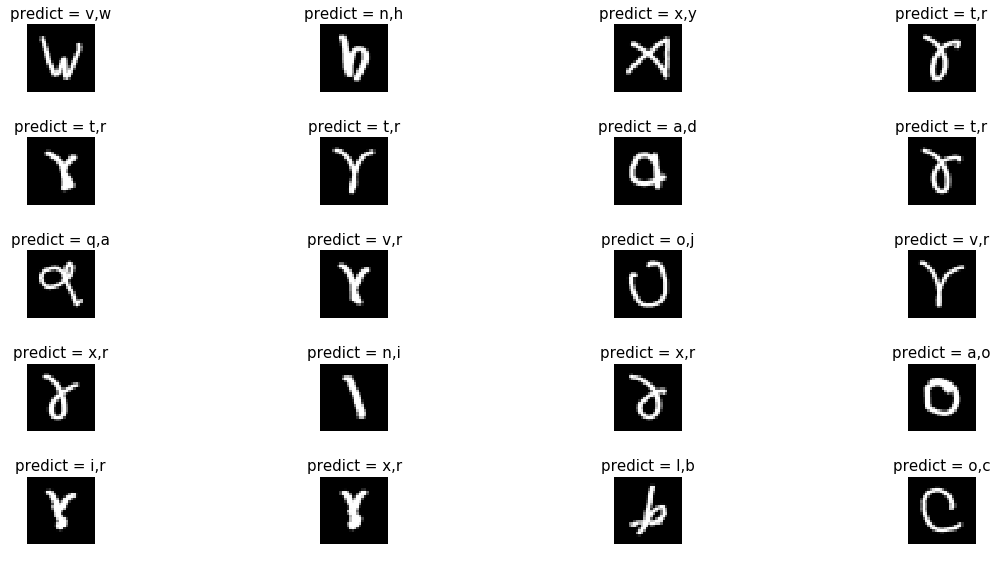

In [9]:
f, ax = plt.subplots(5, 4, figsize=(18,8))

for i,j in enumerate(list_):
    if(i > 19):
        break
    image = X_test[j].reshape(28,28)
    ax[i//4,i%4].imshow(image, cmap = cmp.gray)
    ax[i//4,i%4].set_title('predict = {},{}'.format(chr(97+ np.argmax(pred[j],0)),chr(97 + true_value[j])),fontsize= 15)
    ax[i//4,i%4].axis('off')
plt.tight_layout()
plt.savefig('cnn_image.png')

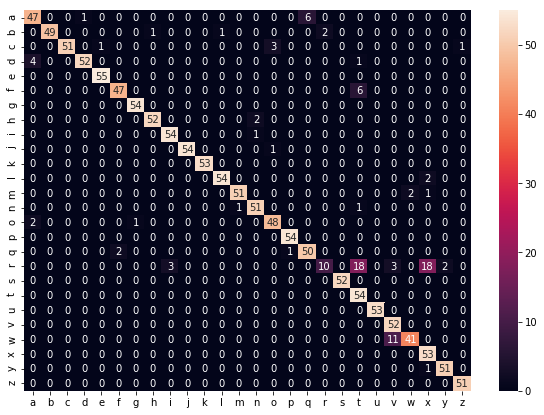

In [10]:
cm = confusion_matrix(true_value, predict_value)
df_cm = pd.DataFrame(cm, index = [i for i in "abcdefghijklmnopqrstuvwxyz"],
                  columns = [i for i in "abcdefghijklmnopqrstuvwxyz"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_map_cnn.png')
plt.show()

In [11]:
# minmax 실행
train_x = dp_train.point[:,:,0].reshape((-1,1))
test_x = dp_test.point[:,:,0].reshape((-1,1))

train_y = dp_train.point[:,:,1].reshape((-1,1))
test_y = dp_test.point[:,:,1].reshape((-1,1))

data_x = scaler.fit_transform(train_x).reshape((-1,64,1))
data_test_x = scaler.transform(test_x).reshape((-1,64,1))

data_y = scaler_.fit_transform(train_y).reshape((-1,64,1))
data_test_y = scaler_.transform(test_y).reshape((-1,64,1))

data = np.hstack((data_x,data_y)).reshape((-1,64,2),order='F')
data_test = np.hstack((data_test_x,data_test_y)).reshape((-1,64,2),order='F')

#train set test set 나누기
X_train = data[:,:,:]
#X_train_ = copy.deepcopy(dp.point)
X_test = data_test[:,:,:]
X_test_ = copy.deepcopy(data[:,:,:])

X_train_img = dp_train.images[:]
X_test_img = dp_test.images[:]
Y_train = dp_train.label[:]
Y_test = dp_test.label[:]


Y_train = keras.utils.to_categorical(Y_train,num_classes=class_num, dtype='float32')
Y_test = keras.utils.to_categorical(Y_test,num_classes=class_num, dtype='float32')

/home/kist-student/anaconda3/envs/tensor/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kist-student/anaconda3/envs/tensor/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
input_1 = Input(shape=(28, 28, 1))

#x_1 = conv1_layer_2(input_1)
#x_1 = conv2_layer_2(x_1)

x_1 = Conv2D(32, kernel_size=3, padding="valid", activation = 'relu')(input_1)
x_1 = BatchNormalization()(x_1)
x_1 = ReLU()(x_1)
x_1 = Dropout(0.45)(x_1)

x_1 = Conv2D(64, kernel_size=3, padding="valid", activation = 'relu')(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = ReLU()(x_1)
x_1 = Dropout(0.45)(x_1)

x_1 = Conv2D(128, kernel_size=3, padding="valid", activation = 'relu')(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = ReLU()(x_1)
x_1 = Dropout(0.45)(x_1)

x_1 = Conv2D(256, kernel_size=3, padding="valid", activation = 'relu')(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = ReLU()(x_1)
x_1 = Dropout(0.45)(x_1)

x_1 = GlobalAveragePooling2D()(x_1)
x_1 = Dropout(0.45)(x_1)


# lstm part
input_2 = Input(shape=(64, 2))

x_2 = Conv1D(32,kernel_size=4, padding='same',strides=1)(input_2)
x_2 = BatchNormalization(momentum=0.8)(x_2)
x_2 = LeakyReLU(0.2)(x_2)
x_2 = Dropout(0.5)(x_2)

x_2 = Conv1D(64,kernel_size=5, strides=1, padding='same')(x_2)
x_2 = BatchNormalization(momentum=0.8)(x_2)
x_2 = LeakyReLU(alpha=0.2)(x_2)
x_2 = Dropout(0.5)(x_2)

x_2 = Conv1D(128, kernel_size=6, strides=1, padding='same')(x_2)
x_2 = BatchNormalization(momentum=0.8)(x_2)
x_2 = LeakyReLU(0.2)(x_2)
x_2 = Dropout(0.5)(x_2)


x_2 = Conv1D(256, kernel_size=7, strides=1, padding='same')(x_2)
x_2 = BatchNormalization(momentum=0.8)(x_2)
x_2 = LeakyReLU(0.2)(x_2)
x_2 = Dropout(0.5)(x_2)

x_2 = Conv1D(512, kernel_size=8, strides=1, padding='same')(x_2)
x_2 = BatchNormalization(momentum=0.8)(x_2)
x_2 = LeakyReLU(0.2)(x_2)
x_2 = Dropout(0.5)(x_2)

x_2 = GlobalAveragePooling1D()(x_2)



merged = concatenate([x_1,x_2])

m = Dense(class_num, activation='softmax')(merged)

model = Model(inputs=[input_1, input_2], outputs = m)


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 2)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64, 32)       288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 64, 32)       128         conv1d_1[0][0]                   
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
leaky_re_l

In [14]:
model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(lr=0.001,epsilon=1e-04),
                metrics=['accuracy'])

hist_2 = model.fit([X_train_img,X_train],Y_train,epochs=250,batch_size=128,validation_data=([X_test_img,X_test],Y_test),callbacks=[cb_checkpoint,lr_reduce])


Train on 7047 samples, validate on 1393 samples
Epoch 1/250
7047/7047 [==============================] - 7s 935us/step - loss: 1.8917 - acc: 0.4487 - val_loss: 1.7022 - val_acc: 0.4393

Epoch 00001: val_acc did not improve from 0.93108
Epoch 2/250
7047/7047 [==============================] - 3s 438us/step - loss: 0.8779 - acc: 0.7666 - val_loss: 1.2747 - val_acc: 0.5966

Epoch 00002: val_acc did not improve from 0.93108
Epoch 3/250
7047/7047 [==============================] - 3s 436us/step - loss: 0.5225 - acc: 0.8723 - val_loss: 0.7130 - val_acc: 0.7717

Epoch 00003: val_acc did not improve from 0.93108
Epoch 4/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.3457 - acc: 0.9160 - val_loss: 0.6132 - val_acc: 0.8062

Epoch 00004: val_acc did not improve from 0.93108
Epoch 5/250
7047/7047 [==============================] - 3s 433us/step - loss: 0.2593 - acc: 0.9403 - val_loss: 0.5376 - val_acc: 0.8370

Epoch 00005: val_acc did not improve from 0.93108
Epoch 6/250


7047/7047 [==============================] - 3s 435us/step - loss: 0.0243 - acc: 0.9946 - val_loss: 0.2249 - val_acc: 0.9368

Epoch 00043: val_acc did not improve from 0.95047
Epoch 44/250
7047/7047 [==============================] - 3s 440us/step - loss: 0.0200 - acc: 0.9949 - val_loss: 0.1917 - val_acc: 0.9462

Epoch 00044: val_acc did not improve from 0.95047
Epoch 45/250
7047/7047 [==============================] - 3s 438us/step - loss: 0.0170 - acc: 0.9965 - val_loss: 0.2151 - val_acc: 0.9404

Epoch 00045: val_acc did not improve from 0.95047
Epoch 46/250
7047/7047 [==============================] - 3s 452us/step - loss: 0.0159 - acc: 0.9967 - val_loss: 0.2068 - val_acc: 0.9426

Epoch 00046: val_acc did not improve from 0.95047
Epoch 47/250
7047/7047 [==============================] - 3s 457us/step - loss: 0.0185 - acc: 0.9947 - val_loss: 0.1892 - val_acc: 0.9447

Epoch 00047: val_acc did not improve from 0.95047
Epoch 48/250
7047/7047 [==============================] - 3s 462us/s

7047/7047 [==============================] - 3s 435us/step - loss: 0.0122 - acc: 0.9970 - val_loss: 0.2360 - val_acc: 0.9332

Epoch 00086: val_acc did not improve from 0.95047
Epoch 87/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.0102 - acc: 0.9976 - val_loss: 0.2542 - val_acc: 0.9304

Epoch 00087: val_acc did not improve from 0.95047
Epoch 88/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.0103 - acc: 0.9973 - val_loss: 0.2245 - val_acc: 0.9404

Epoch 00088: val_acc did not improve from 0.95047
Epoch 89/250
7047/7047 [==============================] - 3s 437us/step - loss: 0.0112 - acc: 0.9974 - val_loss: 0.2461 - val_acc: 0.9318

Epoch 00089: val_acc did not improve from 0.95047
Epoch 90/250
7047/7047 [==============================] - 3s 436us/step - loss: 0.0093 - acc: 0.9982 - val_loss: 0.2560 - val_acc: 0.9232

Epoch 00090: val_acc did not improve from 0.95047
Epoch 91/250
7047/7047 [==============================] - 3s 438us/s

7047/7047 [==============================] - 3s 433us/step - loss: 0.0069 - acc: 0.9990 - val_loss: 0.2206 - val_acc: 0.9411

Epoch 00129: val_acc did not improve from 0.95047
Epoch 130/250
7047/7047 [==============================] - 3s 433us/step - loss: 0.0078 - acc: 0.9987 - val_loss: 0.2261 - val_acc: 0.9390

Epoch 00130: val_acc did not improve from 0.95047
Epoch 131/250
7047/7047 [==============================] - 3s 435us/step - loss: 0.0075 - acc: 0.9986 - val_loss: 0.1957 - val_acc: 0.9440

Epoch 00131: val_acc did not improve from 0.95047
Epoch 132/250
7047/7047 [==============================] - 3s 433us/step - loss: 0.0068 - acc: 0.9983 - val_loss: 0.2014 - val_acc: 0.9419

Epoch 00132: val_acc did not improve from 0.95047
Epoch 133/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.0071 - acc: 0.9987 - val_loss: 0.2187 - val_acc: 0.9419

Epoch 00133: val_acc did not improve from 0.95047
Epoch 134/250
7047/7047 [==============================] - 3s 43

7047/7047 [==============================] - 3s 434us/step - loss: 0.0079 - acc: 0.9983 - val_loss: 0.2327 - val_acc: 0.9375

Epoch 00172: val_acc did not improve from 0.95047
Epoch 173/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.0074 - acc: 0.9984 - val_loss: 0.1924 - val_acc: 0.9469

Epoch 00173: val_acc did not improve from 0.95047
Epoch 174/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.0060 - acc: 0.9987 - val_loss: 0.2066 - val_acc: 0.9404

Epoch 00174: val_acc did not improve from 0.95047
Epoch 175/250
7047/7047 [==============================] - 3s 432us/step - loss: 0.0070 - acc: 0.9987 - val_loss: 0.2078 - val_acc: 0.9419

Epoch 00175: val_acc did not improve from 0.95047
Epoch 176/250
7047/7047 [==============================] - 3s 434us/step - loss: 0.0069 - acc: 0.9990 - val_loss: 0.1934 - val_acc: 0.9462

Epoch 00176: val_acc did not improve from 0.95047
Epoch 177/250
7047/7047 [==============================] - 3s 43

7047/7047 [==============================] - 3s 440us/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.1955 - val_acc: 0.9483

Epoch 00215: val_acc did not improve from 0.95047
Epoch 216/250
7047/7047 [==============================] - 3s 437us/step - loss: 0.0067 - acc: 0.9990 - val_loss: 0.1962 - val_acc: 0.9419

Epoch 00216: val_acc did not improve from 0.95047
Epoch 217/250
7047/7047 [==============================] - 3s 441us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.1929 - val_acc: 0.9447

Epoch 00217: val_acc did not improve from 0.95047
Epoch 218/250
7047/7047 [==============================] - 3s 438us/step - loss: 0.0062 - acc: 0.9990 - val_loss: 0.2317 - val_acc: 0.9354

Epoch 00218: val_acc did not improve from 0.95047
Epoch 219/250
7047/7047 [==============================] - 3s 443us/step - loss: 0.0077 - acc: 0.9982 - val_loss: 0.1964 - val_acc: 0.9462

Epoch 00219: val_acc did not improve from 0.95047
Epoch 220/250
7047/7047 [==============================] - 3s 43

In [15]:
score = model.evaluate([X_test_img,X_test],Y_test)
scores = model.predict([X_test_img,X_test])
true_value = np.argmax(Y_test,1)
predict_value = np.argmax(scores,1)
list_ = []
for i in range(np.size(true_value,0)):
  if(true_value[i] != predict_value[i]):
    print('t:{},p:{}'.format(true_value[i],predict_value[i]))
    list_.append(i)

1393/1393 [==============================] - 0s 266us/step
t:8,p:20
t:22,p:21
t:7,p:1
t:2,p:14
t:24,p:0
t:17,p:21
t:17,p:21
t:3,p:0
t:17,p:19
t:22,p:21
t:6,p:16
t:17,p:21
t:17,p:21
t:17,p:21
t:17,p:19
t:14,p:0
t:17,p:21
t:17,p:21
t:10,p:15
t:17,p:19
t:1,p:17
t:17,p:19
t:17,p:19
t:22,p:21
t:22,p:21
t:22,p:20
t:17,p:21
t:17,p:21
t:22,p:20
t:12,p:23
t:17,p:21
t:2,p:8
t:17,p:19
t:22,p:21
t:17,p:19
t:17,p:21
t:17,p:21
t:1,p:17
t:10,p:15
t:22,p:21
t:3,p:19
t:2,p:4
t:17,p:21
t:23,p:0
t:7,p:13
t:2,p:14
t:17,p:21
t:22,p:20
t:16,p:5
t:10,p:15
t:17,p:21
t:12,p:0
t:17,p:21
t:17,p:21
t:2,p:8
t:17,p:19
t:17,p:21
t:2,p:14
t:17,p:21
t:8,p:20
t:17,p:21
t:17,p:21
t:16,p:5
t:17,p:21
t:2,p:14
t:17,p:21
t:3,p:8
t:17,p:19
t:17,p:21
t:1,p:7
t:10,p:15
t:24,p:20
t:22,p:21
t:17,p:21
t:22,p:21
t:17,p:21
t:1,p:7
t:2,p:8
t:22,p:21
t:22,p:21
t:17,p:19
t:0,p:16
t:17,p:19
t:17,p:21
t:22,p:21


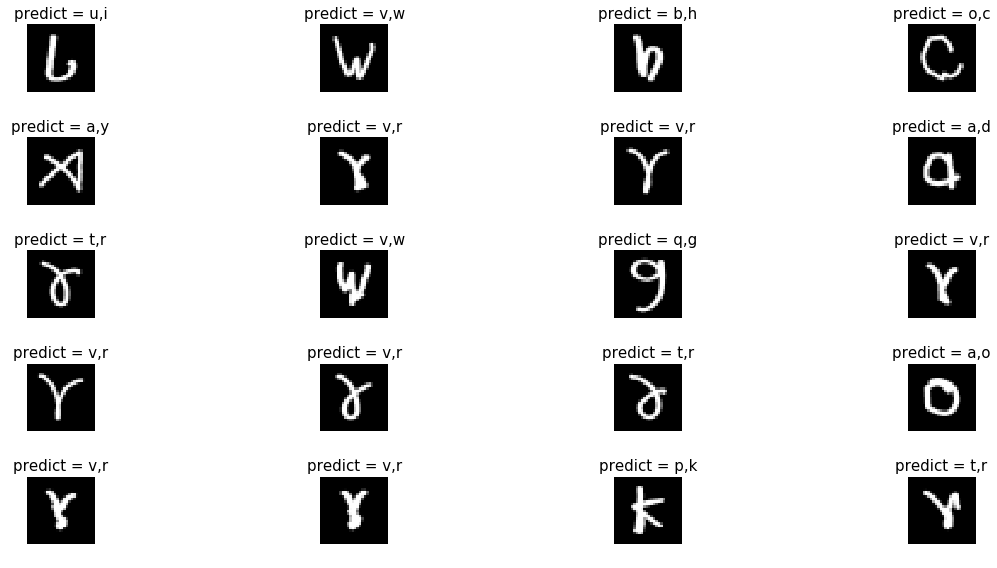

In [16]:
f, ax = plt.subplots(5, 4, figsize=(18,8))

for i,j in enumerate(list_):
    if(i > 19):
        break
    image = X_test_img[j].reshape(28,28)
    ax[i//4,i%4].imshow(image, cmap=cmp.gray)
    ax[i//4,i%4].set_title('predict = {},{}'.format(chr(97+ predict_value[j]),chr(97 + true_value[j])),fontsize=15)
    ax[i//4,i%4].axis('off')
plt.tight_layout()
plt.savefig('lstm_image.png')

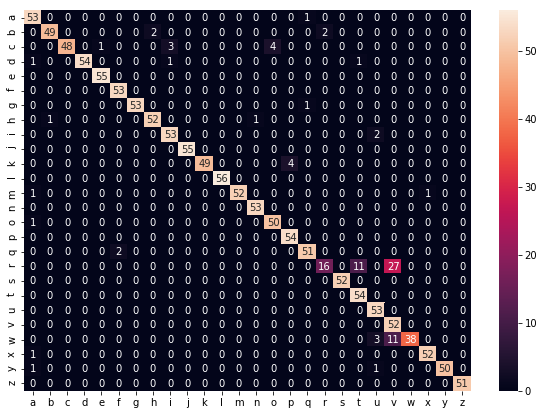

In [17]:
cm = confusion_matrix(true_value, predict_value)
df_cm = pd.DataFrame(cm, index = [i for i in "abcdefghijklmnopqrstuvwxyz"],
                  columns = [i for i in "abcdefghijklmnopqrstuvwxyz"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_map_lstm.png')
plt.show()

In [18]:
print(list_)

[31, 41, 56, 61, 64, 120, 145, 146, 163, 166, 188, 191, 219, 228, 245, 249, 250, 251, 288, 296, 303, 352, 364, 373, 386, 390, 396, 402, 427, 448, 479, 537, 553, 561, 584, 591, 602, 614, 618, 672, 673, 681, 692, 701, 705, 743, 753, 761, 778, 791, 803, 807, 848, 894, 910, 914, 920, 922, 923, 954, 969, 1045, 1069, 1100, 1119, 1121, 1141, 1153, 1173, 1174, 1190, 1202, 1203, 1216, 1235, 1281, 1292, 1315, 1327, 1339, 1342, 1344, 1372, 1382, 1383]


In [19]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

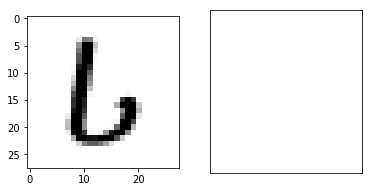

In [20]:
for i in list_:
    X_test_img_ = X_test_img[i].reshape((28,28))
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test_img_,cmap=plt.cm.binary)
    #plot_image(i, scores, Y_test, X_test_img)
    plt.subplot(1,2,2)
    plot_value_array(i, scores,  Y_test)
    plt.xticks([0,1,2,3,4,5,6,7,8,9], ('0','1', '2', '3', '4', '5','6','7','8','9'))
    print(i)
plt.show()


No handles with labels found to put in legend.


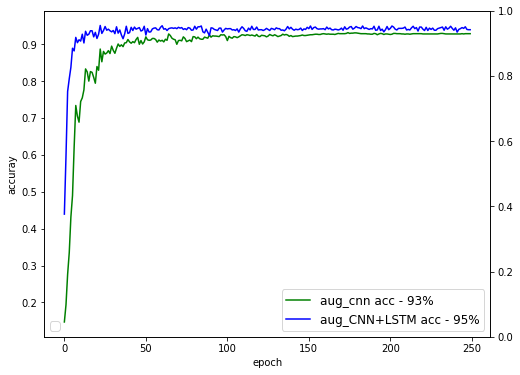

In [22]:
fig, loss_ax = plt.subplots(figsize=(8,6))

acc_ax = loss_ax.twinx()

loss_ax.plot(hist_1.history['val_acc'], 'g', label='aug_cnn acc - 93%')
loss_ax.plot(hist_2.history['val_acc'], 'b', label='aug_CNN+LSTM acc - 95%')
#loss_ax.plot(hist_3.history['val_acc'], 'b', label='aug_LSTM acc')

#acc_ax.plot(hist_1_.history['val_acc'], 'r', label='cnn acc - 99.6%')
#acc_ax.plot(hist_2_.history['val_acc'], 'y', label='CNN+LSTM acc - 99.7%')
#acc_ax.plot(hist_3_.history['val_acc'], 'k', label='LSTM acc')



loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('accuray')


acc_ax.legend(loc='lower left',fontsize='large')
loss_ax.legend(loc='lower right',fontsize='large')
plt.savefig('accuracy_2')
plt.show()


In [ ]:
print(list_)

In [ ]:
plt.imshow(X_test_img[503].reshape((28,28)))